## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 64 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai.vision import *
from minivggnet import *
bs=64

## Downloading Dataset

TO download data CIFAR 10 data use following command

path = untar_data(URLs.CIFAR);
path


By running the above command, the data is downloaded and stored in the path shown above. Let's look at how the data directory is set up as we have to import data from these directories. Let's start by looking at path directory, and we can see below that our data already have training and testing folder.

In [3]:
path = Path('../data/cifar10/')

Let's look inside the training folder. Data is split by digits 1 to 9 in a different folder.

In [4]:
path.ls()

[WindowsPath('../data/cifar10/labels.txt'),
 WindowsPath('../data/cifar10/models'),
 WindowsPath('../data/cifar10/test'),
 WindowsPath('../data/cifar10/train')]

In [5]:
(path/'train').ls()

[WindowsPath('../data/cifar10/train/airplane'),
 WindowsPath('../data/cifar10/train/automobile'),
 WindowsPath('../data/cifar10/train/bird'),
 WindowsPath('../data/cifar10/train/cat'),
 WindowsPath('../data/cifar10/train/deer'),
 WindowsPath('../data/cifar10/train/dog'),
 WindowsPath('../data/cifar10/train/frog'),
 WindowsPath('../data/cifar10/train/horse'),
 WindowsPath('../data/cifar10/train/ship'),
 WindowsPath('../data/cifar10/train/truck')]

Within each digit folder, we have images.

In [6]:
(path/'train/airplane').ls()[1:5]

[WindowsPath('../data/cifar10/train/airplane/10010_airplane.png'),
 WindowsPath('../data/cifar10/train/airplane/10020_airplane.png'),
 WindowsPath('../data/cifar10/train/airplane/10024_airplane.png'),
 WindowsPath('../data/cifar10/train/airplane/10031_airplane.png')]

## Importing Data

In [4]:
data = (ImageItemList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms=None, size=32)
        .databunch(bs=bs))

In [5]:
data.train_ds

LabelList
y: CategoryList (50000 items)
[Category airplane, Category airplane, Category airplane, Category airplane, Category airplane]...
Path: ..\data\cifar10
x: ImageItemList (50000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: ..\data\cifar10

In [6]:
data.valid_ds

LabelList
y: CategoryList (10000 items)
[Category airplane, Category airplane, Category airplane, Category airplane, Category airplane]...
Path: ..\data\cifar10
x: ImageItemList (10000 items)
[Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32), Image (3, 32, 32)]...
Path: ..\data\cifar10

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
10


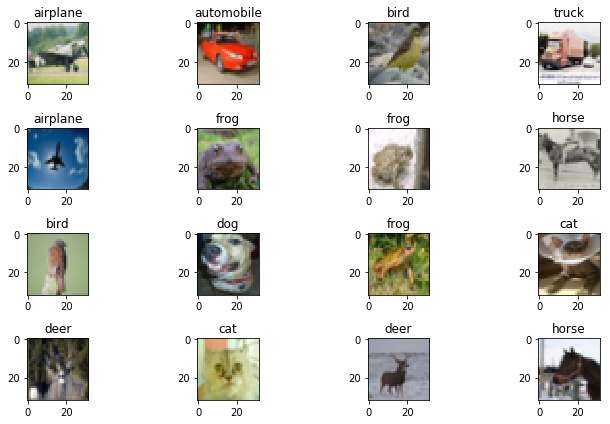

In [7]:
print(data.classes) ## Prints class labels
print(data.c) ## Prints number of classes
data.show_batch(rows=4, figsize=(10,6), hide_axis=False) ## Show sample data

## About the model

Minivggnet is just a smaller version of VGG family of model which contains all the key elements to build an actual VGG model. It's just miniature version which can do reasonably well without requiring a lot of compute time. The model is having following architecture -

((CONV=>ACT=>BN)x2 =>POOL=>DO)x2=>FC=>ACT=>DO=>FC=>SOFTMAX

Glossary-
- CONV -> Convolution with kernel size 3x3 with same padding
- ACT -> ReLU Activation
- BN -> Batch Normalization
- DO -> Dropout
- Pool -> Max pooling with size 2x2
- FC -> Fully connected layer

## Training the model

We have defined our shallownet model in shallownet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [11]:
## Defining the learner
minivgg_learner = Learner(data=data, 
                          model=MiniVGGNet(batch_norm=True, size=32, n_class=data.c), 
                          loss_func=nn.CrossEntropyLoss(),
                          metrics=accuracy)

In [12]:
minivgg_learner.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 32, 32, 32]     896        True      
______________________________________________________________________
ReLU                 [64, 32, 32, 32]     0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32, 32]     64         True      
______________________________________________________________________
Conv2d               [64, 32, 32, 32]     9248       True      
______________________________________________________________________
ReLU                 [64, 32, 32, 32]     0          False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32, 32]     64         True      
______________________________________________________________________
MaxPool2d            [64, 32, 16, 16]     0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


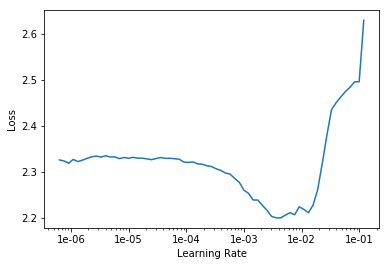

In [13]:
## Finidng Ideal learning late
minivgg_learner.lr_find()
minivgg_learner.recorder.plot()

In [15]:
minivgg_learner.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.213189,1.092167,0.614800
2,0.924720,0.841663,0.704400
3,0.750805,0.767476,0.738900
4,0.578265,0.578782,0.804000
5,0.471615,0.569754,0.807700


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


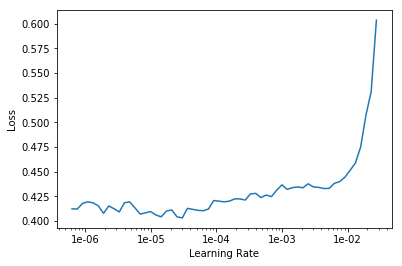

In [17]:
## Finidng Ideal learning late
minivgg_learner.lr_find()
minivgg_learner.recorder.plot()

In [18]:
minivgg_learner.fit_one_cycle(5,1e-5)

epoch,train_loss,valid_loss,accuracy
1,0.445613,0.563316,0.810200
2,0.449382,0.564051,0.808400
3,0.445852,0.563414,0.809800
4,0.430402,0.561455,0.811100
5,0.438141,0.561199,0.810200


In [15]:
from sklearn.metrics import classification_report
interp = ClassificationInterpretation.from_learner(sn_learner)
print(classification_report(interp.y_true,interp.pred_class))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1000
           1       0.67      0.68      0.67      1000
           2       0.39      0.39      0.39      1000
           3       0.38      0.35      0.36      1000
           4       0.47      0.48      0.48      1000
           5       0.42      0.43      0.42      1000
           6       0.63      0.66      0.64      1000
           7       0.62      0.58      0.60      1000
           8       0.68      0.69      0.68      1000
           9       0.64      0.62      0.63      1000

   micro avg       0.55      0.55      0.55     10000
   macro avg       0.55      0.55      0.55     10000
weighted avg       0.55      0.55      0.55     10000



As we can see we are reaching 81% accuracy just by using simple MiniVggnet as compared to 10% if we have picked classes at random.